# Part 2 Neural Network

In [1]:
import mlrose_hiive
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import learning_curve, ShuffleSplit
import matplotlib.pyplot as plt
import statistics

In [2]:
df = pd.read_csv("./data/bodyPerformance.csv")

df["gender"] = (df["gender"] != "M").astype(float)

scaler = MinMaxScaler()
encoder = OneHotEncoder()

x = df.iloc[:,:-1]
y = df.iloc[:,-1]

# test train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_scaled = scaler.fit_transform(x)
y_labeled = encoder.fit_transform(y.values.reshape(-1,1)).todense()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

y_train_labeled = encoder.fit_transform(y_train.values.reshape(-1,1)).todense()
y_test_labeled = encoder.fit_transform(y_test.values.reshape(-1,1)).todense()

In [3]:
# learning curve adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        scoring="f1_weighted",
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def generate_metrics(model, model_name):
    model_train_pred = model.predict(x_train_scaled)
    print("NN " + model_name + " Train f1 score", f1_score(y_train_labeled, model_train_pred, average="weighted"))
    print("NN " + model_name + " Train accuracy score", accuracy_score(y_train_labeled, model_train_pred))
    model_test_pred = model.predict(x_test_scaled)
    print("NN " + model_name + " Test f1 score", f1_score(y_test_labeled, model_test_pred, average="weighted"))
    print("NN " + model_name + " Test accuracy score", accuracy_score(y_test_labeled, model_test_pred))

### NN with RHC

In [6]:
nn_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes=[10], 
                                    activation="tanh", 
                                    algorithm="random_hill_climb",
                                    max_iters=5000,
                                    bias=True,
                                    is_classifier=True,
                                    learning_rate=0.1,
                                    early_stopping=True,
                                    clip_max=1e+10,
                                    max_attempts=500,
                                    random_state=0)

nn_rhc.fit(x_train_scaled, y_train_labeled)

NeuralNetwork(activation='tanh', early_stopping=True, hidden_nodes=[10],
              max_attempts=500, max_iters=5000, random_state=0)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

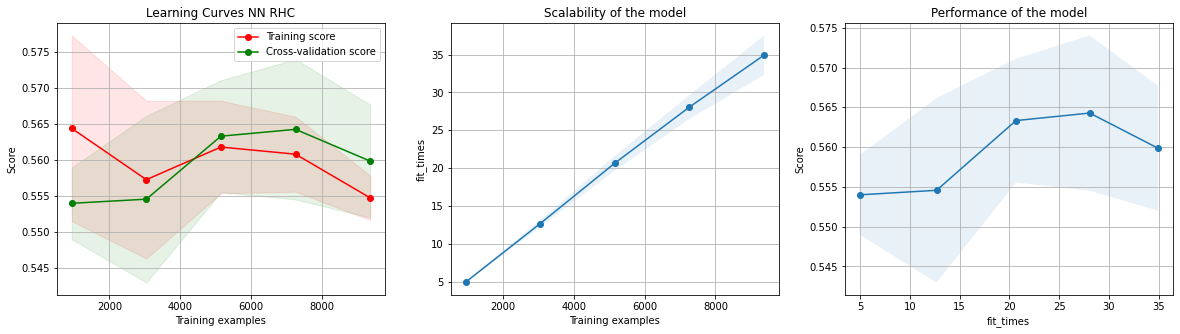

In [7]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

plot_learning_curve(nn_rhc, 
                    "Learning Curves NN RHC", 
                    x_scaled, 
                    y_labeled,  
                    cv=cv, 
                    n_jobs=-1)

In [8]:
generate_metrics(nn_rhc, "randomize hill climb")

NN randomize hill climb Train f1 score 0.5682033764488591
NN randomize hill climb Train accuracy score 0.5735466666666666
NN randomize hill climb Test f1 score 0.5321254744566546
NN randomize hill climb Test accuracy score 0.5594823295171727


### NN with GD

In [9]:
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes=[10], 
                                    activation="tanh", 
                                    algorithm="gradient_descent",
                                    max_iters=5000,
                                    bias=True,
                                    is_classifier=True,
                                    learning_rate=0.1,
                                    early_stopping=True,
                                    clip_max=1e+10,
                                    max_attempts=500,
                                    random_state=0)

nn_gd.fit(x_train_scaled, y_train_labeled)

NeuralNetwork(activation='tanh', algorithm='gradient_descent',
              early_stopping=True, hidden_nodes=[10], max_attempts=500,
              max_iters=5000, random_state=0)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

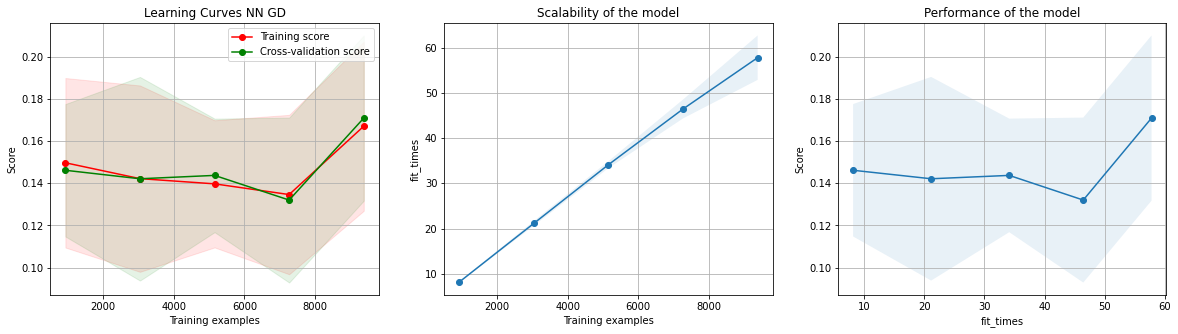

In [10]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

plot_learning_curve(nn_gd, 
                    "Learning Curves NN GD", 
                    x_scaled, 
                    y_labeled,  
                    cv=cv, 
                    n_jobs=-1)

In [11]:
generate_metrics(nn_gd, "Gradient Descent")

NN Gradient Descent Train f1 score 0.11586111097085164
NN Gradient Descent Train accuracy score 0.23968
NN Gradient Descent Test f1 score 0.12099927429914868
NN Gradient Descent Test accuracy score 0.2269785963165754


### NN with SA

In [12]:
nn_sa = mlrose_hiive.NeuralNetwork(hidden_nodes=[10], 
                                    activation="tanh", 
                                    algorithm="simulated_annealing",
                                    schedule=mlrose_hiive.ExpDecay(5),
                                    max_iters=5000,
                                    bias=True,
                                    is_classifier=True,
                                    learning_rate=0.1,
                                    early_stopping=True,
                                    clip_max=1e+10,
                                    max_attempts=500,
                                    random_state=0)

nn_sa.fit(x_train_scaled, y_train_labeled)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing',
              early_stopping=True, hidden_nodes=[10], max_attempts=500,
              max_iters=5000, random_state=0,
              schedule=ExpDecay(init_temp=5, exp_const=0.005, min_temp=0.001))

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

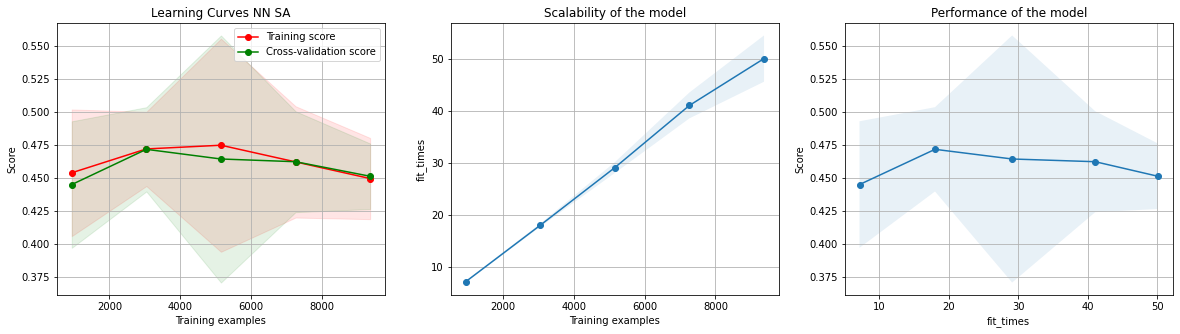

In [13]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

plot_learning_curve(nn_sa, 
                    "Learning Curves NN SA", 
                    x_scaled, 
                    y_labeled,  
                    cv=cv, 
                    n_jobs=-1)

In [14]:
generate_metrics(nn_sa, "Simulated Anneling")

NN Simulated Anneling Train f1 score 0.4157567227089115
NN Simulated Anneling Train accuracy score 0.44426666666666664
NN Simulated Anneling Test f1 score 0.2777459496098478
NN Simulated Anneling Test accuracy score 0.34942757590841217


### NN with GA

In [15]:
nn_ga = mlrose_hiive.NeuralNetwork(hidden_nodes=[10], 
                                    activation="tanh", 
                                    algorithm="genetic_alg",
                                    max_iters=100,
                                    bias=True,
                                    is_classifier=True,
                                    learning_rate=0.1,
                                    mutation_prob=0.1,
                                    pop_size=100,
                                    early_stopping=True,
                                    clip_max=1.0,
                                    max_attempts=500,
                                    random_state=0)

nn_ga.fit(x_train_scaled, y_train_labeled)

NeuralNetwork(activation='tanh', algorithm='genetic_alg', clip_max=1.0,
              early_stopping=True, hidden_nodes=[10], max_attempts=500,
              pop_size=100, random_state=0)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

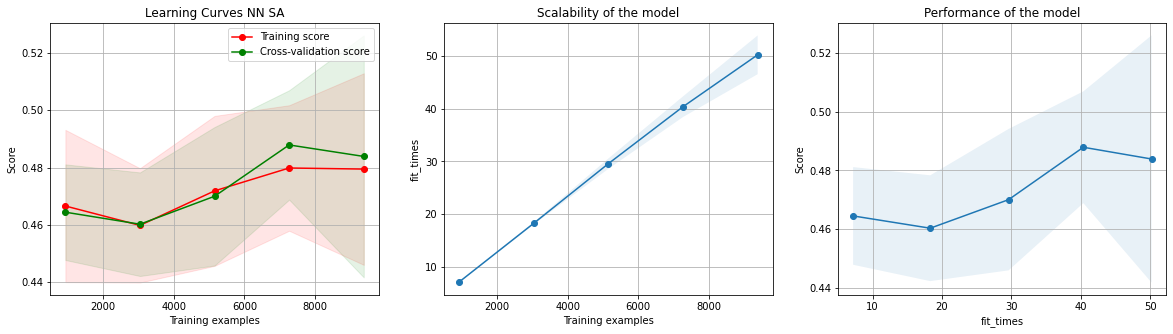

In [16]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

plot_learning_curve(nn_sa, 
                    "Learning Curves NN SA", 
                    x_scaled, 
                    y_labeled,  
                    cv=cv, 
                    n_jobs=-1)

In [17]:
generate_metrics(nn_ga, "Genetic Algorithm")

NN Genetic Algorithm Train f1 score 0.331362335116416
NN Genetic Algorithm Train accuracy score 0.36256
NN Genetic Algorithm Test f1 score 0.3507199110707335
NN Genetic Algorithm Test accuracy score 0.37680438028870084


In [18]:
np.var(x)

age                         185.644189
gender                        0.232524
height_cm                    71.001992
weight_kg                   142.783864
body fat_%                   52.657854
diastolic                   115.382659
systolic                    216.484263
gripForce                   112.879307
sit and bend forward_cm      71.510046
sit-ups counts              203.808896
broad jump_cm              1589.338756
dtype: float64

In [19]:
df.corr()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
age,1.000000,0.060229,-0.293980,-0.099966,0.242302,0.158508,0.211167,-0.179583,-0.070033,-0.544581,-0.435172
gender,0.060229,1.000000,-0.730899,-0.672887,0.551407,-0.228552,-0.323921,-0.800184,0.327467,-0.474596,-0.704149
height_cm,-0.293980,-0.730899,1.000000,0.734909,-0.515440,0.145933,0.210186,0.735024,-0.221970,0.500424,0.674589
weight_kg,-0.099966,-0.672887,0.734909,1.000000,-0.084065,0.262317,0.338943,0.700119,-0.296249,0.294899,0.479564
body fat_%,0.242302,0.551407,-0.515440,-0.084065,1.000000,0.048059,-0.030376,-0.541788,-0.071225,-0.608912,-0.673273
diastolic,0.158508,-0.228552,0.145933,0.262317,0.048059,1.000000,0.676309,0.202062,-0.072098,0.016547,0.097243
systolic,0.211167,-0.323921,0.210186,0.338943,-0.030376,0.676309,1.000000,0.286012,-0.082434,0.056276,0.152894
gripForce,-0.179583,-0.800184,0.735024,0.700119,-0.541788,0.202062,0.286012,1.000000,-0.112577,0.576669,0.746853
sit and bend forward_cm,-0.070033,0.327467,-0.221970,-0.296249,-0.071225,-0.072098,-0.082434,-0.112577,1.000000,0.177153,0.026487
sit-ups counts,-0.544581,-0.474596,0.500424,0.294899,-0.608912,0.016547,0.056276,0.576669,0.177153,1.000000,0.748273
